# Time Series Forecast with simple (not even linear) models and Decision Trees

Here are the references:
- https://www.sarem-seitz.com/posts/winning-with-simple-not-even-linear-time-series-models.html
- https://www.sarem-seitz.com/posts/forecasting-with-decision-trees-and-random-forests.html

In [215]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(321)

Simple Integration of random normally distributed values can lead to "linear-looking" trends and change points in the data even thought there is no linear process generating it.

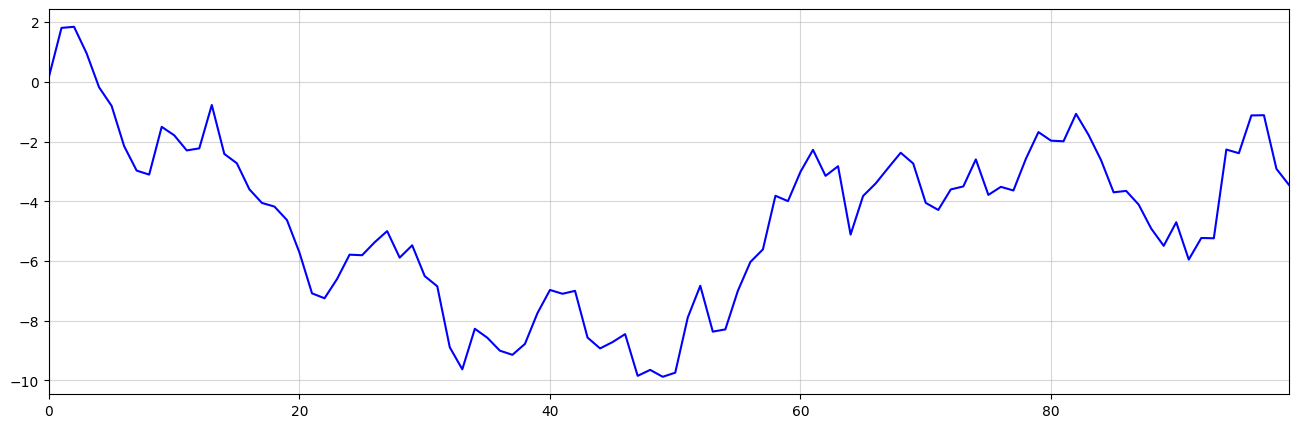

In [216]:
plt.figure(figsize = (16,5))
plt.plot(np.cumsum(np.random.normal(size = 100)),color="blue")
plt.margins(x=0)
plt.grid(alpha=0.5);

In [217]:
# Generate 100 random numbers
white_noise = np.random.normal(size=240)

# reshape to get 25 rows of 4 random values
white_noise = white_noise.reshape((20, 12))

In [218]:
# for each column integrate the numbers to get some random time series
seasonal_series = np.cumsum(white_noise, 0)

# recombine the seasonal effects into one timeseries and add integration for a trend
time_series = np.cumsum(seasonal_series.reshape(-1))

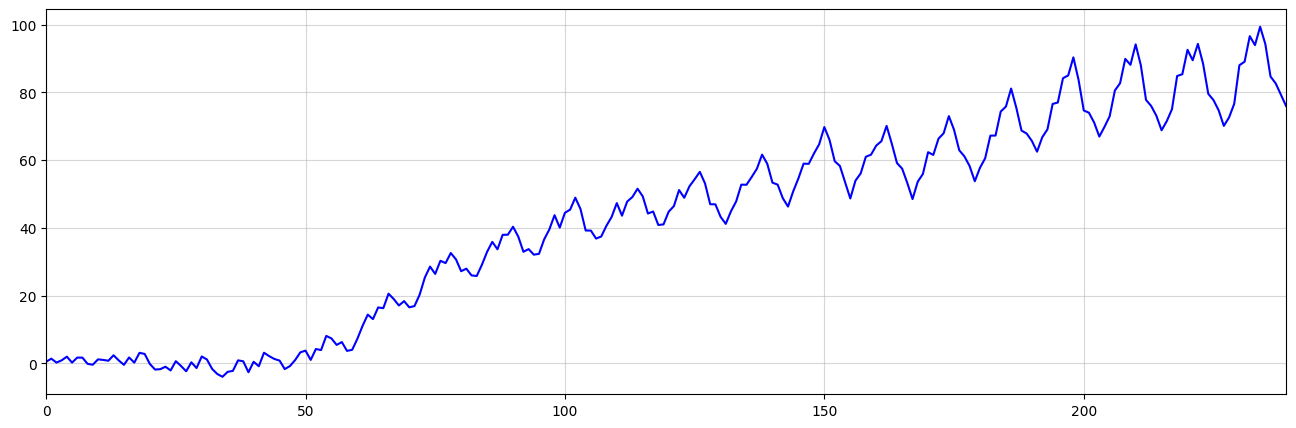

In [219]:
plt.figure(figsize = (16,5))
plt.plot(time_series, color="blue")
plt.margins(x=0)
plt.grid(alpha=0.5);

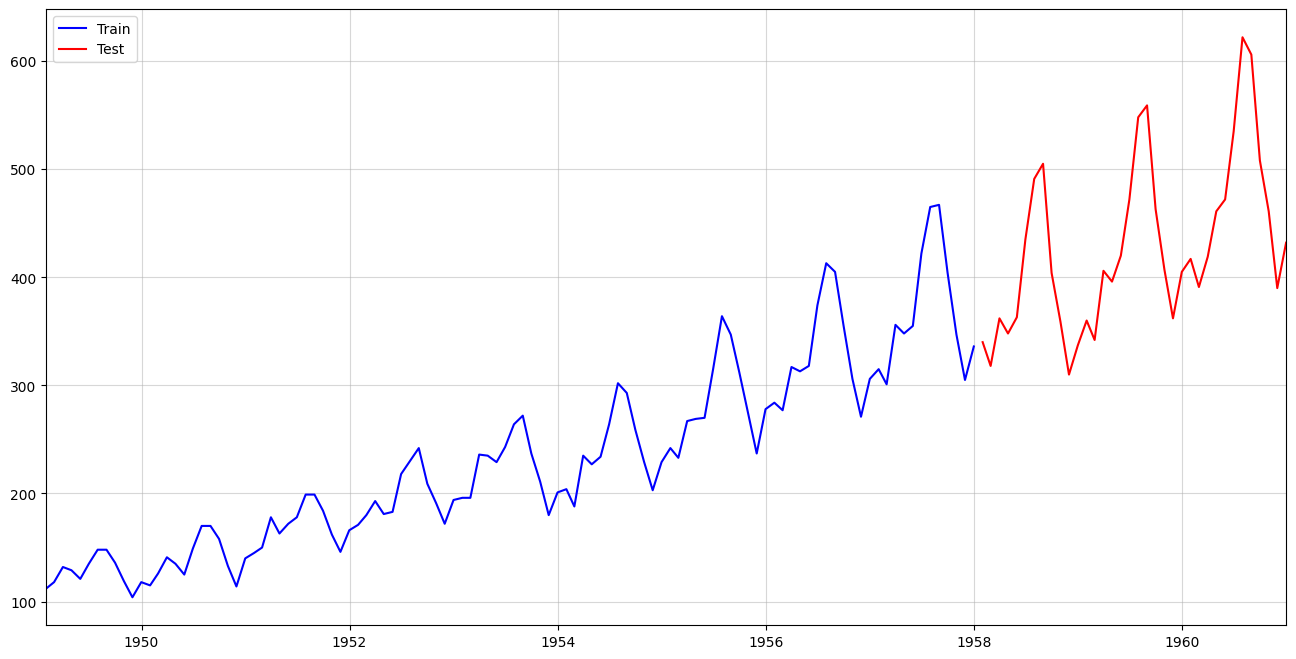

In [220]:
import pandas as pd
from neuralforecast.utils import AirPassengersDF

df = AirPassengersDF.iloc[:,1:]
df.columns = ["date","sales"]
df.index = pd.to_datetime(df["date"])

sales = df["sales"]

train = sales.iloc[:-36]
test = sales.iloc[-36:]

plt.figure(figsize = (16,8))
plt.plot(train,color="blue",label="Train")
plt.plot(test,color="red",label="Test")
plt.legend()
plt.margins(x=0)
plt.grid(alpha=0.5);

Now to make things easier we want to remove both trend and seasonality from the data. We do this by taking the square root which stabilizes the increasing variance. Then we do two differentiations to remove seasonality and trend.

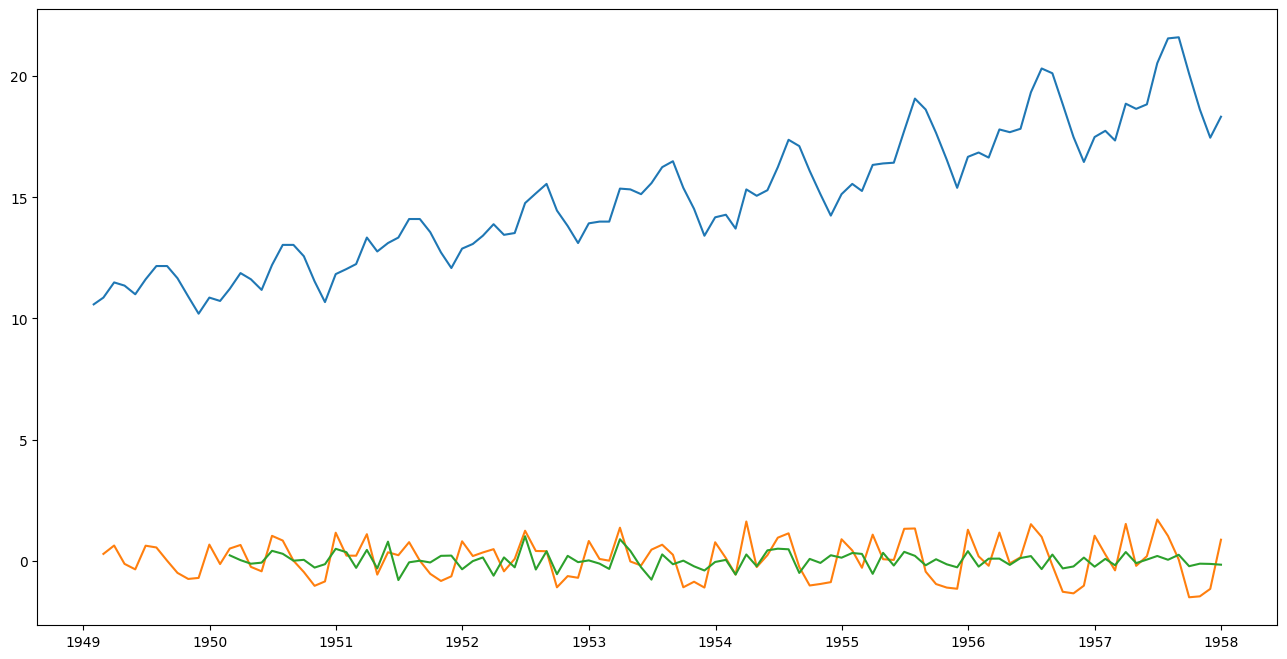

In [221]:
plt.figure(figsize=(16, 8))
less_variance = np.sqrt(train)
plt.plot(less_variance)
no_trend = less_variance.diff(1)
plt.plot(no_trend)
no_seasonality = no_trend.diff(12).dropna()
plt.plot(no_seasonality)
plt.show()

Now our data is even kind of normally distributed.

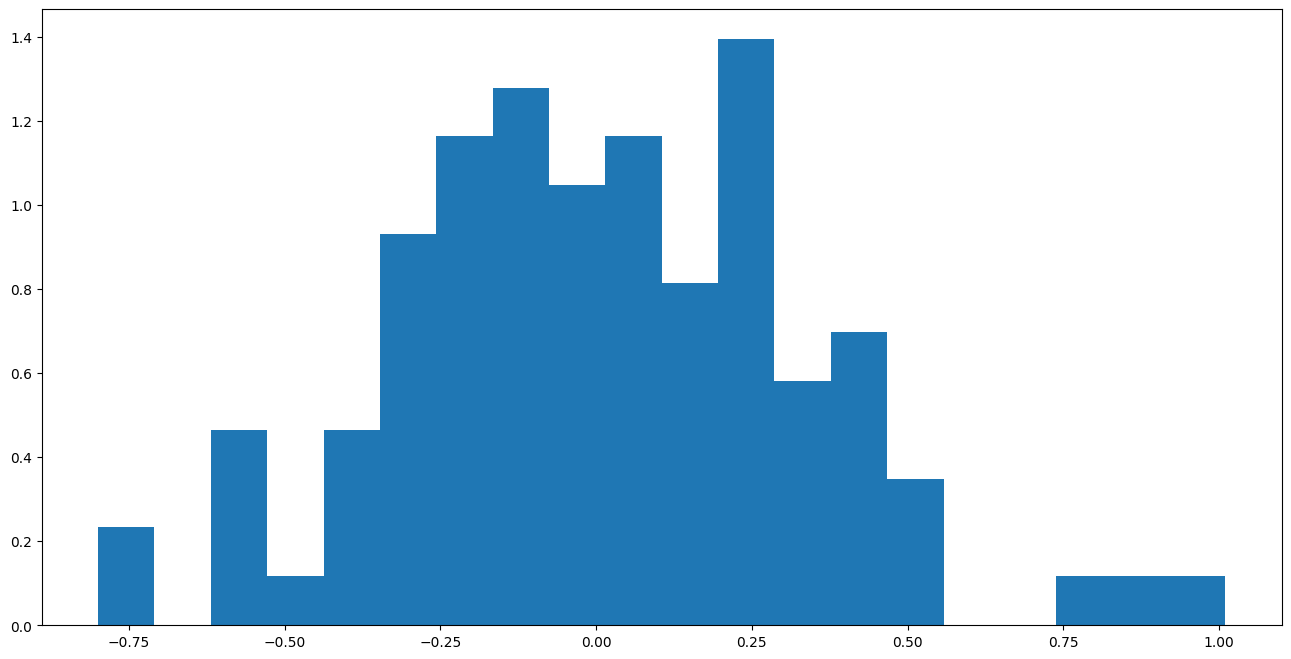

In [222]:
plt.figure(figsize=(16, 8))
plt.hist(no_seasonality, bins=20, density=True)
plt.show()

So now that we know how our data is distributed without all of the influencing factors we can easily sample new data point from this distribution, reapply the trend, seasonailty and variation increase.

I kind of dont like this part here as I think that the author has too much knowledge about the data which makes it really easy to construct a model that fits the data quite well. Otherwise lots of methods he used would not have worked as good as described. 

In [223]:
sample = []
for i in range(10000):
    # draw new samples from our training distribution for each test sample
    draw = np.random.choice(no_seasonality, len(test))
    
    # get the last 12 training points that still has seasonality in it
    result = list(no_trend.iloc[-12:].values)
    
    # now add the test data points by adding the values
    for i, _ in enumerate(test):
        result.append(result[i] + draw[i])
    
    last_value = less_variance.iloc[-1]
    
    # reintroduce the trend for the test data part
    with_trend = np.cumsum(result[12:])
    with_variance = (last_value + with_trend)**2
    
    sample.append(
        np.array(
            with_variance.reshape(-1, 1)
        )
    )


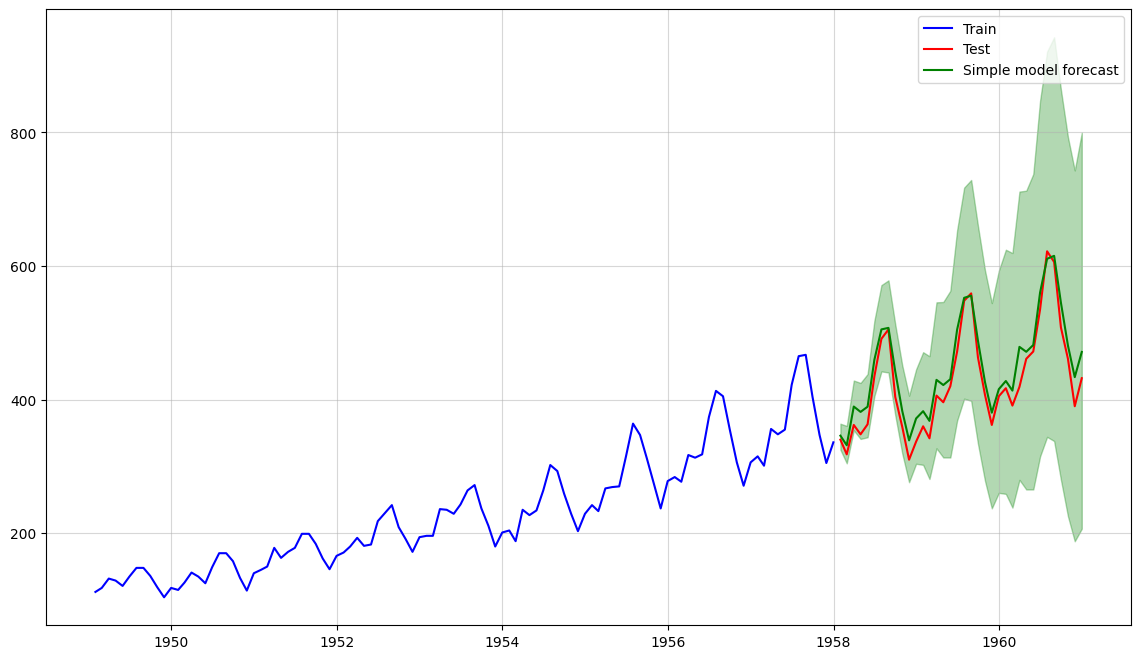

In [224]:
reshaped = np.concatenate(sample, 1)
result_mean = np.mean(reshaped,1)
lower = np.quantile(reshaped,0.05,1)
upper = np.quantile(reshaped,0.95,1)


plt.figure(figsize = (14,8))
plt.plot(train, label = "Train",color="blue")
plt.plot(test, label = "Test",color="red")
plt.grid(alpha = 0.5)

plt.plot(test.index, result_mean,label = "Simple model forecast",color="green")
plt.legend()
plt.fill_between(test.index,lower,upper,alpha=0.3,color="green");


## Some Learnings out of this
- any complex model should be better than pure noise
- integrated noise accounts for auto-correlation
- even random data can exhibit linear trends and change points 
- a seemingly complex time-series could still follow a fairly simple data-generating process
- always start with the simplest possible model and use it as a baseline for all other models to compare to

# Forecasting with Decision Trees and Random Forests

In [225]:
from sklearn.tree import DecisionTreeRegressor

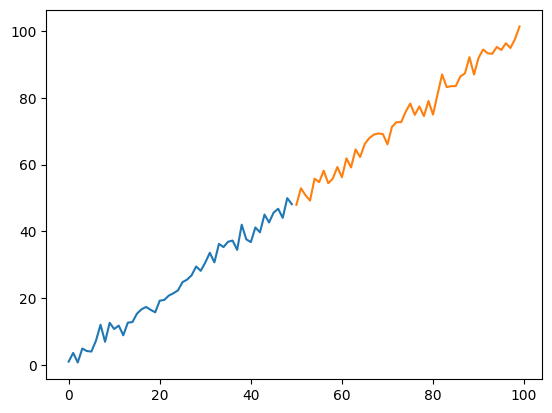

In [226]:
# Generate time component
t = np.arange(100)

# add some randomness to generate a linear positive trend
y = t + 2 * np.random.normal(size=100)

# train test split
y_train, y_test = y[:50], y[50:]
t_train, t_test = t[:50].reshape(-1,1), t[50:].reshape(-1,1)

plt.plot(t_train, y_train)
plt.plot(t_test, y_test)
plt.show()

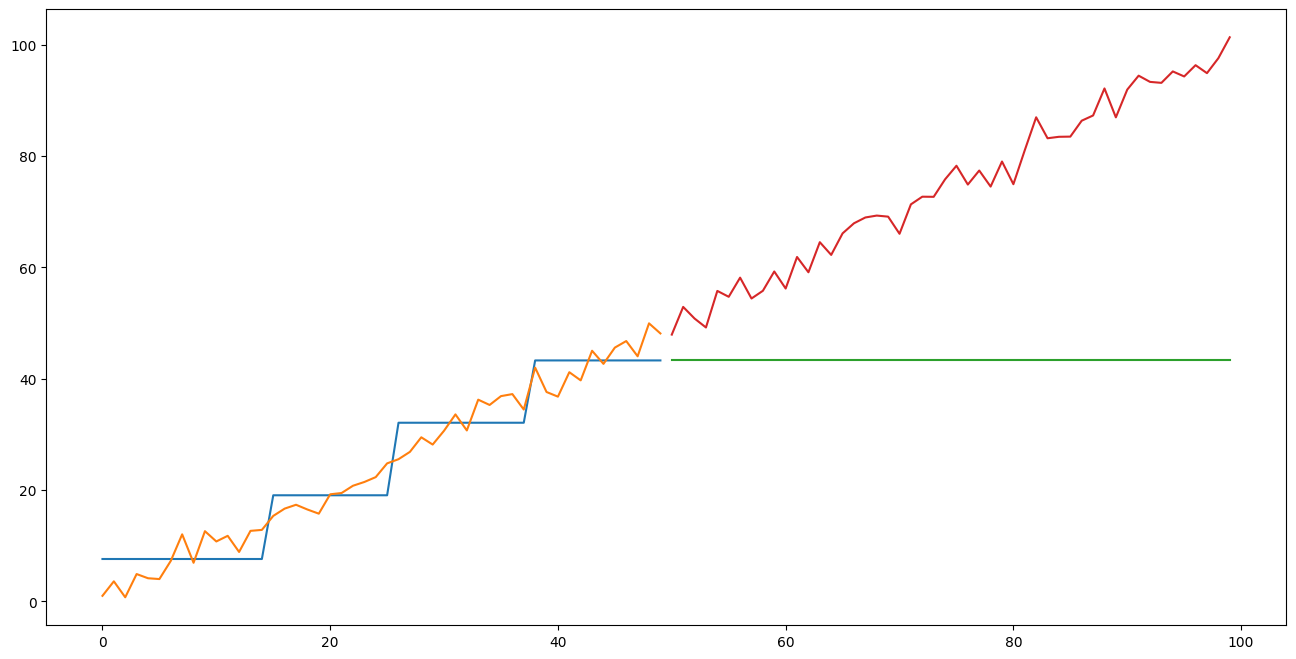

In [227]:
# fit a DecisionTree model to the training data
tree = DecisionTreeRegressor(max_depth=2)
tree.fit(t_train, y_train)

y_pred_train = tree.predict(t_train)
y_pred_test = tree.predict(t_test)

plt.figure(figsize=(16,8 ))
plt.plot(t_train, y_pred_train)
plt.plot(t_train, y_train)
plt.plot(t_test, y_pred_test)
plt.plot(t_test, y_test)
plt.show()

The above seems to fail as the new (test) data is always going to be out of distribution. The distribution of t is from 0 to 50. Of course that data from 50 to 100 is not inside of this distribution.

A better approach is the auto-regressive one where the future values depend on the past values (plus some random fluctuations). We achieve this with lagged variables.
To do this we want to also remove the trend by differencing. 

In [228]:
t = np.arange(100)
y = t + 2 * np.random.normal(size=100)
t_train = t[:50].reshape(-1,1)
t_test = t[50:].reshape(-1,1)

n_lags = 10

y_train = y[:50]
# to create the lagged values we shift the data (using the pandas shift method)
X_train = [pd.DataFrame(y_train).shift(t) for t in range(1, n_lags)]
X_train = pd.concat(X_train, axis=1)
X_train

,0,0,0,0,0,0,0,0,0
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.544420,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1.858413,0.544420,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.051810,-1.858413,0.544420,NaN,NaN,NaN,NaN,NaN,NaN
4,-1.674560,3.051810,-1.858413,0.544420,NaN,NaN,NaN,NaN,NaN
5,6.576226,-1.674560,3.051810,-1.858413,0.544420,NaN,NaN,NaN,NaN
6,2.792140,6.576226,-1.674560,3.051810,-1.858413,0.544420,NaN,NaN,NaN
7,4.469214,2.792140,6.576226,-1.674560,3.051810,-1.858413,0.544420,NaN,NaN
8,6.077343,4.469214,2.792140,6.576226,-1.674560,3.051810,-1.858413,0.544420,NaN
9,8.724712,6.077343,4.469214,2.792140,6.576226,-1.674560,3.051810,-1.858413,0.544420


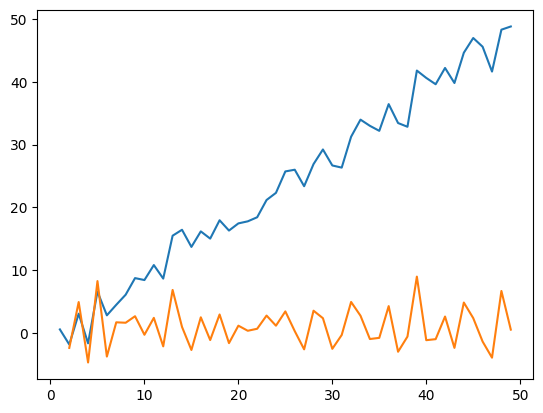

In [229]:
# we can now remove the trend from all lag variables by differencing the data once
plt.plot(X_train.iloc[:, 0])
plt.plot(X_train.iloc[:, 0].diff())

X_train = X_train.diff()

# now we remove any missing values that appeared because of the lagging
X_train = X_train.values[n_lags:, :]

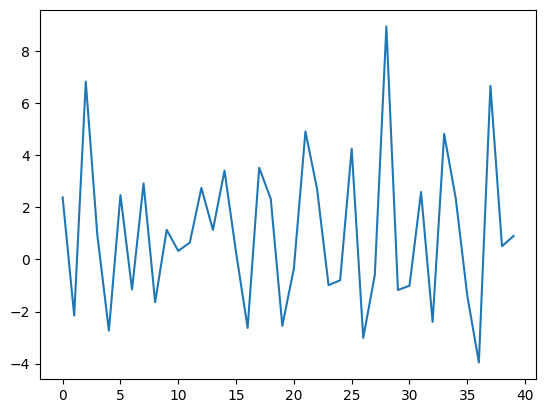

In [230]:
y_train = np.diff(y_train)[n_lags-1:]
plt.plot(y_train)
plt.show()

In [231]:
tree = DecisionTreeRegressor(max_depth=1)
tree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [232]:
y_pred_train = tree.predict(X_train).reshape(-1)

In [233]:
y_pred_train

array([ 2.63737487, -0.15235905,  2.63737487, -0.15235905, -0.15235905,
        2.63737487, -0.15235905,  2.63737487, -0.15235905,  2.63737487,
       -0.15235905, -0.15235905, -0.15235905, -0.15235905, -0.15235905,
       -0.15235905, -0.15235905,  2.63737487, -0.15235905, -0.15235905,
        2.63737487,  2.63737487, -0.15235905, -0.15235905,  2.63737487,
        2.63737487, -0.15235905,  2.63737487,  2.63737487, -0.15235905,
        2.63737487,  2.63737487, -0.15235905,  2.63737487, -0.15235905,
       -0.15235905,  2.63737487,  2.63737487, -0.15235905, -0.15235905])

In [234]:
last_Xtrain_value = X_train[-1, 1:].reshape(1, -1)
last_ytrain_value = np.array(y_train[-1]).reshape(1,1)

Xt = np.concatenate([last_Xtrain_value, last_ytrain_value], axis=1)
Xt.shape

(1, 9)

In [235]:
pred_test = []
for i, _ in enumerate(y_test):
    pred = tree.predict(Xt)
    pred_test.append(pred[0])
    
    pred = np.array(pred).reshape(1,1)
    last_Xtrain_value = Xt[-1, 1:].reshape(1, -1)
    Xt = np.concatenate([pred, last_Xtrain_value], axis=1)

y_pred_test = np.array(pred_test)

y_pred_train = y_train[n_lags-2] + np.cumsum(y_pred_train)
y_pred_test = y_train[-1]+np.cumsum(y_pred_test)